# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [2]:
songs = pd.read_csv('/Users/merlesteffen/Documents/GitHub/Moosic/Data/song_fatures_cleaned.csv', index_col=[0,1])

In [3]:
songs.shape

(5114, 13)

# Columns to keep /drop from Scientific Literature and General Understanding


Certainly! Let's go through each of the features:

__Danceability__:

Recommendation: Keep.
Reason: Represents how suitable a track is for dancing based on various musical elements including tempo, rhythm stability, beat strength, and overall regularity.
Reference:
Jehan, T. (2005). Creating music by listening. PhD thesis, Massachusetts Institute of Technology.

__Energy__:

Recommendation: Keep.
Reason: Measures intensity and activity, typically energetic tracks feel fast and noisy.
Reference:
Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. IEEE Transactions on speech and audio processing, 10(5), 293-302.

Key:

Recommendation: Depends.
Reason: While the key is fundamental in music theory, its efficacy in clustering tasks can be dataset dependent. However, it might be important when distinguishing between certain types of genres or moods.
Reference:
Mardirossian, G., & Chew, E. (2015). Key-independent multi-level tonal analysis for interactive music systems. In Proceedings of the ACM SIGCHI Conference on Human Factors in Computing Systems.

__Loudness__:

Recommendation: Keep but be cautious of its correlation with 'Energy'.
Reason: The perceived volume of the song can distinguish between certain moods or genres.
Reference:
Vickers, E. (2011). The loudness war: Background, speculation and recommendations. Audio Engineering Society Convention 131.

__Mode__:

Recommendation: Keep.
Reason: Major or minor mode can influence the mood or feel of a song.
Reference:
Huron, D. (2008). Sweet Anticipation: Music and the Psychology of Expectation. MIT Press.

__Speechiness__:

Recommendation: Keep.
Reason: Differentiates between talk shows, podcasts, and music.
Reference:
Mesaros, A., Heittola, T., Benetos, E., Foster, P., Lagrange, M., Virtanen, T., & Dixon, S. (2018). Detection and Classification of Acoustic Scenes and Events: Outcome of the DCASE 2016 Challenge. IEEE/ACM Transactions on Audio, Speech, and Language Processing.

__Acousticness__:

Recommendation: Keep.
Reason: Helps distinguish between electronic and acoustic music.
Reference:
Sturm, B. L., Diver, C., & Martinez, A. R. (2013). An evaluation of the audio feature space for detecting fake musical instrument samples.
In Proceedings of the Sound and Music Computing Conference.

__Instrumentalness__:

Recommendation: Keep.
Reason: Determines the presence of vocals in a song, distinguishing between purely instrumental tracks and those with lyrics.
Reference:
Leglaive, S., Hennequin, R., & Badeau, R. (2015). Singing voice detection with deep recurrent neural networks. In IEEE International Conference on Acoustics, Speech and Signal Processing.

__Liveness__:

Recommendation: Keep.
Reason: Identifies the presence of a live audience, differentiating studio recordings from live performances.
Reference:
Dittmar, C., & Müller, M. (2012). Automatic annotation of recorded music. In Multimodal Music Processing (Vol. 3).

__Valence__:

Recommendation: Keep.
Reason: Measures the musical positiveness of a track, can differentiate between moods.
Reference:
Yang, Y. H., & Chen, H. H. (2012). Machine recognition of music emotion: A review. ACM Transactions on Intelligent Systems and Technology (TIST), 3(3).

__Tempo__:

Recommendation: Keep.
Reason: The speed of a track is one of the fundamental aspects of music.
Reference:
Dixon, S. (2001). Automatic extraction of tempo and beat from expressive performances. Journal of New Music Research, 30(1), 39-58.

Duration_ms:

Recommendation: Consider.
Reason: The length of a track might not inherently convey much about its musical content, but it could be relevant depending on the dataset.
Reference:
Not commonly discussed in literature for its inherent musical properties.

Time_signature:

Recommendation: Depends.
Reason: Time signature can be critical for certain genres or analyzing complex rhythmic structures but might be less informative for general clustering tasks.
Reference:
Gouyon, F., Klapuri, A., Dixon, S., Alonso, M., Tzanetakis, G., Uhle, C., & Cano, P. (2006). An experimental comparison of audio tempo induction algorithms. IEEE Transactions on Audio, Speech, and Language Processing, 14(5), 1832-1844.

__DROP__
> time_signature, Duration_ms, Key

Also drop __mode__ since it is binary and we need continuous variables.

In [4]:
songs.drop(columns=['time_signature', 'duration_ms', 'key', 'mode'], inplace = True)

# Scale

## MinMax Scaler

In [5]:
scaler = MinMaxScaler()
songs_scaled = scaler.fit_transform(songs)
songs = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

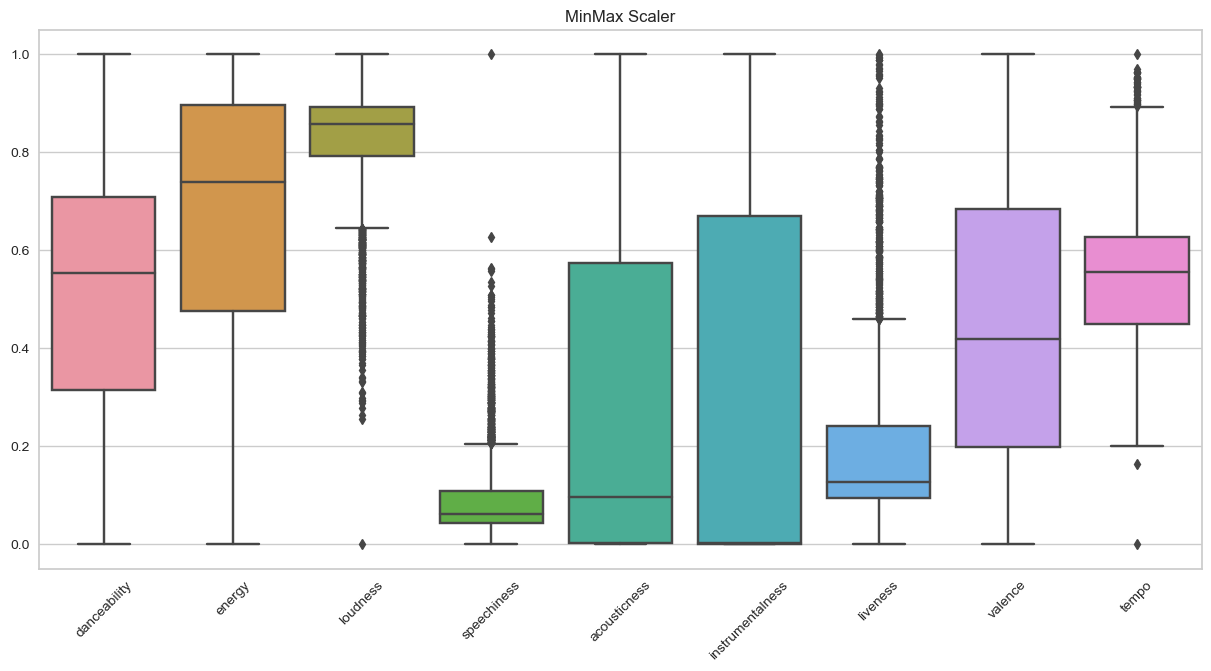

In [6]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs)
plt.title('MinMax Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

# Determining the number of Ks

## Inertia

In [7]:
kmeans = KMeans(n_init=10, n_clusters=48, random_state=213)  # random_state for reproducibility
songs['cluster'] = kmeans.fit_predict(songs)

In [8]:
kmeans.inertia_

333.2942866034077

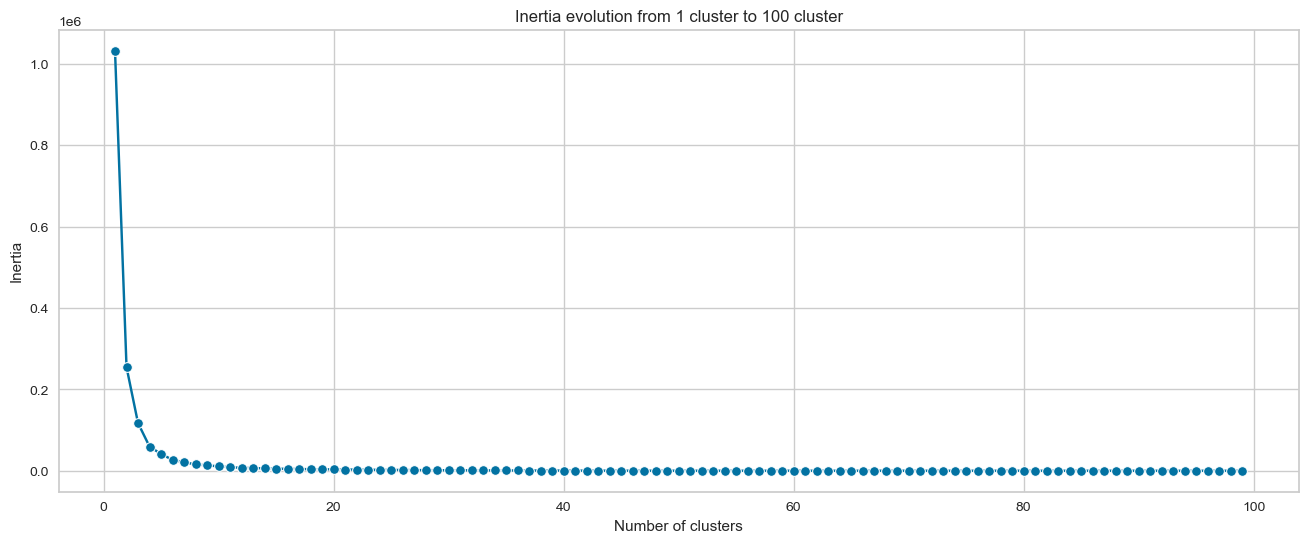

In [9]:
max_k = 100
inertia = []

for k in range(1, max_k):
    inertia.append(KMeans(n_clusters=k, n_init = 10, random_state=213).fit(songs).inertia_)



#then plot the inertia
fig, ax = plt.subplots(figsize=(16, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Silhouette Score

In [10]:
silhouette_score(songs, kmeans.labels_, random_state=213)

0.7401386717367897

In [ ]:
feautures = songs.drop(columns='cluster')

In [ ]:
min_k = 2
max_k = 100
sil_score = []

for k in range(min_k, max_k):
    labels = KMeans(n_clusters=k, n_init= 10, random_state=213).fit(feautures).labels_
    current_silhouette_score = silhouette_score(songs, labels)
    sil_score.append(current_silhouette_score)

#plotting the results
plt.title(f'Silhouette score evolution from {min_k} clusters to {max_k} clusters')
sns.lineplot(x=range(min_k, max_k), y=sil_score, marker='o')
plt.show()

In [ ]:
min_k = 40
max_k = 51
sil_score = []

for k in range(min_k, max_k):
    labels = KMeans(n_clusters=k, n_init= 10, random_state=213).fit(feautures).labels_
    current_silhouette_score = silhouette_score(songs, labels)
    sil_score.append(current_silhouette_score)

#plotting the results
plt.title(f'Silhouette score evolution from {min_k} clusters to {max_k - 1} clusters')
sns.lineplot(x=range(min_k, max_k), y=sil_score, marker='o')
plt.show()

Conclusion we see that 48 clusters are ideal.

# K-Means

Let's say you would prefer the MinMax Scaler since it makes readability and explanations easier, but you do not want to drop all outliers. Another idea would be to implement weights to the oberservations. The further an pbservation from their cluster, the lower their weight. 

In [ ]:
kmeans = KMeans(n_init=10, n_clusters=48, random_state=213)  # random_state for reproducibility
songs['cluster'] = kmeans.fit_predict(songs)

# Evaluating the Model

## Silhouette Score

Definition: The Silhouette Score measures how close each point in one cluster is to the points in the neighboring clusters.

Silhouette Score:
Range: The silhouette score ranges from -1 to 1.

Interpretation:

- Near +1: The clusters are well apart from each other and clearly distinguished.
- 0: The clusters are overlapping and there is considerable intermingling.
- Near -1: Points have been assigned to the wrong clusters.

General Guideline:

over 0.7: A strong structure has been found.

0.5 - 0.7: A reasonable structure has been found.

0.25 - 0.5: The structure is weak and could be artificial. Try additional cluster evaluation metrics and techniques.

< 0.25: No substantial structure has been found.

In [ ]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

## Davies-Bouldin Index

The Davies-Bouldin index signifies the average 'similarity' ratio of each cluster with its most similar cluster. Here, 'similarity' is a measure that compares the distance between clusters with the size of the clusters themselves.

Range: The DB index values start from 0 and can be infinite.

Interpretation:

- Lower values: Indicate better clustering. Ideally, you want the DB index to be as close to 0 as possible.
- Higher values: Indicate that the clusters are less dense and/or more separated.

General Guideline:

As with any heuristic, there's no strict threshold for a "good" DB index value because it largely depends on the dataset. Still, lower is better. If you try different clustering configurations or algorithms, you'd prefer the one with a lower DB index over others.

In [ ]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

The best model so far is the Normal K-Means using the MinMax Scaler

# Improving the Model

## Principal Component Analysis

In [ ]:
# Initialize PCA
pca = PCA()
songs_no_cluster = songs.drop('cluster', axis=1, errors='ignore') # errors='ignore' ensures no error if the column doesn't exist
# Fit and transform the data
songs_pca = pca.fit_transform(songs_no_cluster)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
pd.DataFrame(pca.components_, columns=songs_no_cluster.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

In [ ]:
for i in range(1,10):
    pca = PCA(n_components=i, random_state=213)
    songs_pca = pca.fit_transform(songs_no_cluster)
    kmeans = KMeans(n_init=10, n_clusters=48, random_state=213)  # or the number of clusters you've determined

    # Fit the model and predict cluster labels
    clusters = kmeans.fit_predict(songs_pca)

    # Add to your dataframe
    songs['cluster'] = clusters
    silhouette_avg = silhouette_score(songs_pca, songs['cluster'], random_state=213)
    print(f"The average silhouette score for {i} number of components is:", silhouette_avg)

Conclusion. PCA is not a great method. Let us move on.

## Feature Importance

### Extra Trees Classifier

In [ ]:
# Tree model classifiers
songs_without_cluster = songs.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

In [ ]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Conclusion: Keep all features since their importance is above at least 1%. Maybe look at correlation.

### Correlational Adjustments

Impact on Distance-based Models: In K-means or hierarchical clustering, correlated features might lead to distorted distances and thus clusters.

#### Correlation Matrix of Features

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [ ]:
# Assuming songs_robust is your DataFrame
songs_cluster = songs.drop('cluster', axis=1)
correlation_matrix = songs_cluster[songs_cluster.columns].corr()

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Dropping/ Keeping Variables

In [ ]:
songs_uncorrelated = songs.drop(columns=['energy', 'danceability', 'cluster'])
# think about dropping danceability and energy due to correlation

In [ ]:
kmeans = KMeans(n_init=10, n_clusters=48, random_state=213)  # random_state for reproducibility
songs_uncorrelated['cluster'] = kmeans.fit_predict(songs_uncorrelated)

In [ ]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_uncorrelated, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

#### Looking at the two models

In [ ]:
songs_uncorrelated.loc[songs_uncorrelated['cluster']==45].sample(10)

In [ ]:
# Group by 'cluster' column and count observations
cluster_counts = songs_uncorrelated.groupby('cluster').size().sort_values(ascending=False)

cluster_counts

In [ ]:
kmeans = KMeans(n_init=10, n_clusters=48, random_state=213)  # random_state for reproducibility
songs_uncorrelated['cluster'] = kmeans.fit_predict(songs_uncorrelated)
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_uncorrelated, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Conclusion: The best model so far drops energy, danceability and uses the K-Means model while applying the MinMax Scaler. However, musically it makes more sense to include the two dropped variables, and thus, it gives another hint at the K-means model being inapprotriate for clustering songs.

In [ ]:
# Group by 'cluster' column and count observations
cluster_counts = songs.groupby('cluster').size().sort_values(ascending=False)

cluster_counts

In [ ]:
songs.loc[songs['cluster']==25].sample(10)

# Radarplot

# Export

In [ ]:
# songs = songs_uncorrelated.copy()

In [ ]:
songs = songs.reset_index()

In [ ]:
songs.to_csv('/Users/merlesteffen/Documents/GitHub/Moosic/Data/playlists.csv', index=False)

In [ ]:
songs_uncorrelated.to_csv('/Users/merlesteffen/Documents/GitHub/Moosic/Data/playlists_2.csv', index=False)

In [ ]:
print('This worked well.')